In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist

from torch import nn
from torch.autograd import Variable

In [2]:
train_set = mnist.MNIST('./data', train=True, download=True)
test_set = mnist.MNIST('./data', train=False, download=True)

In [3]:
a_data,a_label=train_set[0]

In [4]:
a_data

In [5]:
a_label

tensor(5)

In [6]:
a_data = np.array(a_data, dtype='float32')
print(a_data.shape)

(28, 28)


In [7]:
print(a_data)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

In [8]:
def data_tf(x):
    x=np.array(x,dtype='float32') / 255
    x=(x-0.5)/0.5
    x=x.reshape((-1,))
    x=torch.from_numpy(x)
    return x

In [9]:
train_set=mnist.MNIST('./data',train=True,transform=data_tf,download=True)
test_set=mnist.MNIST('./data',train=True,transform=data_tf,download=True)

In [10]:
a,a_label=train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
tensor(5)


In [11]:
from torch.utils.data import DataLoader
train_data=DataLoader(train_set,batch_size=64,shuffle=True)
test_data=DataLoader(test_set,batch_size=128,shuffle=False)

In [12]:
a,a_label=next(iter(train_data))

In [13]:
print(a.shape)
print(a_label)

torch.Size([64, 784])
tensor([5, 3, 4, 2, 8, 1, 7, 1, 3, 0, 8, 5, 6, 1, 9, 5, 1, 6, 7, 4, 9, 1, 7, 4,
        3, 9, 2, 2, 5, 2, 7, 1, 4, 9, 1, 7, 0, 1, 0, 4, 7, 1, 0, 2, 3, 3, 3, 3,
        6, 8, 9, 4, 8, 7, 7, 1, 5, 4, 8, 0, 1, 5, 1, 1])


In [14]:
net=nn.Sequential(
    nn.Linear(784,400),
    nn.ReLU(),
    nn.Linear(400,200),
    nn.ReLU(),
    nn.Linear(200,100),
    nn.ReLU(),
    nn.Linear(100,10)
)

In [15]:
net

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)

In [16]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),1e-1)

In [17]:
import time
losses=[]
acces=[]
eval_losses=[]
eval_acces=[]
net=net.cuda()
start_time=time.time()
for e in range(20):
    train_loss=0
    train_acc=0
    net.train()
    for im,label in train_data:
        im=Variable(im).cuda()
        label=Variable(label).cuda()
        out=net(im)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.data
        _,pred=out.max(1)
#         print(pred)
#         print('-'*50)
#         print(label)
        num_correct=((pred==label).sum())
#         print(num_correct)
#         print(im.shape[0])
#         print('**'*50)
        acc=num_correct/im.shape[0]
        
        train_acc+=acc.cpu().numpy()
#         print(train_acc/len(train_data))
    losses.append(train_loss/len(train_data))
    acces.append(train_acc/len(train_data))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im).cuda()
        label = Variable(label).cuda()
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.data
        # 记录准确率
        _, pred = out.max(1)
#         print(pred)
#         print('-'*50)
#         print(label)
        num_correct = (pred == label).sum()
#         print(num_correct)
        acc = num_correct / im.shape[0]
        eval_acc += acc.cpu().numpy()
        eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))
    
end_time=time.time()
print('use time:',end_time-start_time)

epoch: 0, Train Loss: 0.519971, Train Acc: 0.004264, Eval Loss: 0.277201, Eval Acc: 0.000000
epoch: 1, Train Loss: 0.160568, Train Acc: 0.049041, Eval Loss: 0.186298, Eval Acc: 0.004264
epoch: 2, Train Loss: 0.115654, Train Acc: 0.105544, Eval Loss: 0.186017, Eval Acc: 0.000000
epoch: 3, Train Loss: 0.089383, Train Acc: 0.185501, Eval Loss: 0.064236, Eval Acc: 0.083156
epoch: 4, Train Loss: 0.074215, Train Acc: 0.221748, Eval Loss: 0.111811, Eval Acc: 0.012793
epoch: 5, Train Loss: 0.061182, Train Acc: 0.310235, Eval Loss: 0.043601, Eval Acc: 0.204691
epoch: 6, Train Loss: 0.052512, Train Acc: 0.363539, Eval Loss: 0.047741, Eval Acc: 0.200426
epoch: 7, Train Loss: 0.044184, Train Acc: 0.404051, Eval Loss: 0.038664, Eval Acc: 0.230277
epoch: 8, Train Loss: 0.037037, Train Acc: 0.461620, Eval Loss: 0.049017, Eval Acc: 0.168443
epoch: 9, Train Loss: 0.033520, Train Acc: 0.524520, Eval Loss: 0.251651, Eval Acc: 0.002132
epoch: 10, Train Loss: 0.030641, Train Acc: 0.530917, Eval Loss: 0.030

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

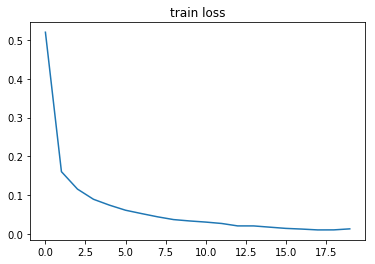

In [19]:
plt.title("train loss")
plt.plot(np.arange(len(losses)),losses)

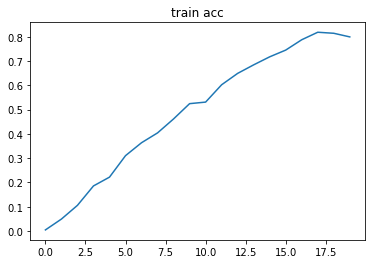

In [20]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')

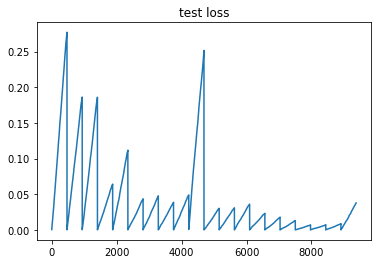

In [21]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')

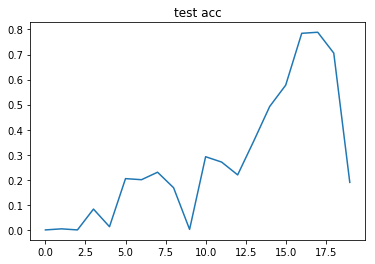

In [22]:
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')